In [2]:
import os
import numpy as np
import pandas as pd
import tqdm
import cv2
import time
from matplotlib import image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.metrics import Recall

## Build Dataset
* https://medium.com/%E9%9B%9E%E9%9B%9E%E8%88%87%E5%85%94%E5%85%94%E7%9A%84%E5%B7%A5%E7%A8%8B%E4%B8%96%E7%95%8C/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-ml-note-cnn%E6%BC%94%E5%8C%96%E5%8F%B2-alexnet-vgg-inception-resnet-keras-coding-668f74879306

* https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/

* https://blog.francium.tech/build-your-own-image-classifier-with-tensorflow-and-keras-dc147a15e38e

In [4]:
# Read label data 
col_name = ["filename", "Grade"]
df = pd.read_csv("Sample_Label.csv", names = col_name) #, encoding = 'unicode_escape')
df["Grade"] = [grade[-1] for grade in df.Grade] # Get rid of the characters other than A, B, C 
df

,filename,Grade
0,D-Plant2_0610_3.jpg,B
1,D-Plant2_0610_30.jpg,C
2,D-Plant2_0610_300.jpg,B
3,D-Plant2_0610_301.jpg,B
4,D-Plant2_0610_302.jpg,B
...,...,...
89,G-Plant2_0616_95.jpg,B
90,G-Plant2_0616_96.jpg,A
91,G-Plant2_0616_97.jpg,A
92,G-Plant2_0616_98.jpg,A


Type: uint8
Shape: (816, 1088, 3)


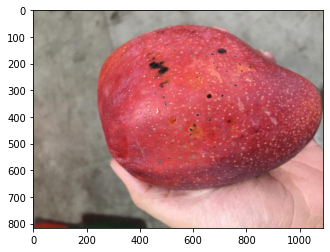

Type: uint8
Shape: (224, 224, 3)


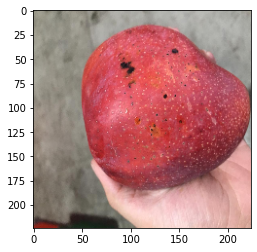

In [5]:
path = "sample_image/D-Plant2_0610_4.jpg"
# path = os.path.join(path, "User/Desktop", "file.txt")
data = cv2.imread(path)
data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
print("Type:", data.dtype)
print("Shape:", data.shape)

# display the array of pixels as an image
plt.imshow(data)
plt.show()

# resize the image
data_resized = cv2.resize(data, (224, 224))
print("Type:", data_resized.dtype)
print("Shape:", data_resized.shape)
# display the array of pixels as an image
plt.imshow(data_resized)
plt.show()

In [7]:
def load_data(dirname, df, onehot=False):
    """
    Path: path to image files
    label: DataFrame with file names and grade
    """
    if onehot:
        enc = OneHotEncoder(handle_unknown='ignore')
        Y = enc.fit_transform(df.Grade.values.reshape(-1, 1)).toarray()
    else:
        Y = df.Grade.values
    
    X = []
    for i in range(len(df)):
        fname = df.filename[i]
        fpath = os.path.join(dirname, fname)
        img = cv2.imread(fpath, )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # show in RGB
        img_resized = cv2.resize(img, (224, 224))
        
        if i == 0:
            X = np.array(img_resized, dtype="float") / 255
        else:
            X = np.concatenate([X, np.array(img_resized, dtype="float") / 255], axis=0)
        
    X = np.reshape(X, [-1, 224, 224, 3])
    return X, Y, enc

In [8]:
path = "sample_image"
X, Y, enc = load_data(path, df, onehot = True)

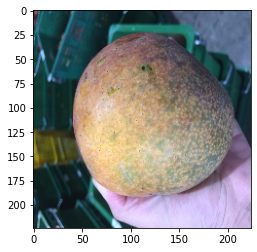

In [11]:
plt.imshow(np.reshape(X[0], [224, 224, -1]))
plt.show()

## Preprocessing
* one-hot encoding
* train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [13]:
(X_train, y_train)

(array([[[[0.33333333, 0.44313725, 0.39215686],
          [0.35686275, 0.44705882, 0.40392157],
          [0.54117647, 0.62352941, 0.58823529],
          ...,
          [0.61960784, 0.21568627, 0.21176471],
          [0.6       , 0.2       , 0.19215686],
          [0.58039216, 0.17647059, 0.16862745]],
 
         [[0.46666667, 0.58823529, 0.56470588],
          [0.61960784, 0.7254902 , 0.70588235],
          [0.56078431, 0.65490196, 0.63529412],
          ...,
          [0.6       , 0.25098039, 0.23529412],
          [0.60784314, 0.25490196, 0.23921569],
          [0.58039216, 0.22745098, 0.21176471]],
 
         [[0.51764706, 0.61960784, 0.59215686],
          [0.56862745, 0.65098039, 0.62745098],
          [0.34901961, 0.42352941, 0.40392157],
          ...,
          [0.57647059, 0.29803922, 0.26666667],
          [0.57254902, 0.29019608, 0.2627451 ],
          [0.56862745, 0.28235294, 0.25490196]],
 
         ...,
 
         [[0.17254902, 0.20784314, 0.19607843],
          [0.13333

## Building Model
* Metrics: *WAR*(Weighted Average Recall)
> *WAR* = 
\begin{equation*}
\ \sum_{i=1}^I w(i) \cdot Recall(i), where \space I = 3
\end{equation*}


In [14]:
# Build model

def EasyNet():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation=tf.nn.softmax)], name='Easy')
    
    return model


easy_model = EasyNet()
easy_model.summary()

Model: "Easy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0      

In [18]:
import tensorflow.python.keras.metrics
from tensorflow.keras import backend as K

In [19]:
def WAR(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)),axis=0) #in catagory
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)),axis=0) #in catagory
    weight = possible_positives/K.sum(possible_positives)
    WAR = K.sum(weight*true_positives/possible_positives)
    
    #weight_1 = possible_positives[0]/K.sum(possible_positives)
    #weight_2 = possible_positives[1]/K.sum(possible_positives)
    #weight_3 = possible_positives[2]/K.sum(possible_positives)
    #recall_ = weight_1*true_positives[0] / (possible_positives[0] + K.epsilon())+weight_2*true_positives[1] / (possible_positives[1] + K.epsilon())+weight_3*true_positives[2] / (possible_positives[2] + K.epsilon())
    return WAR

In [ ]:
easy_model.compile(optimizer = keras.optimizers.Adam(),
                   loss = 'categorical_crossentropy',
                   metrics=["accuracy", tf.keras.metrics.Recall(), WAR])

history = easy_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=2)

Epoch 1/20
4/4 - 31s - loss: 4.0430 - accuracy: 0.4167 - recall_1: 0.3167 - WAR: 0.3229 - val_loss: 0.9811 - val_accuracy: 0.5333 - val_recall_1: 0.0000e+00 - val_WAR: 0.0000e+00
Epoch 2/20
4/4 - 27s - loss: 1.1175 - accuracy: 0.3667 - recall_1: 0.0833 - WAR: 0.0781 - val_loss: 1.0755 - val_accuracy: 0.6000 - val_recall_1: 0.0000e+00 - val_WAR: 0.0000e+00
Epoch 3/20
4/4 - 32s - loss: 1.1107 - accuracy: 0.3000 - recall_1: 0.0500 - WAR: 0.0521 - val_loss: 1.0111 - val_accuracy: 0.5333 - val_recall_1: 0.0000e+00 - val_WAR: 0.0000e+00
Epoch 4/20
4/4 - 25s - loss: 1.0805 - accuracy: 0.3500 - recall_1: 0.0000e+00 - WAR: 0.0000e+00 - val_loss: 1.0278 - val_accuracy: 0.6000 - val_recall_1: 0.0000e+00 - val_WAR: 0.0000e+00
Epoch 5/20
4/4 - 35s - loss: 1.0744 - accuracy: 0.2833 - recall_1: 0.0000e+00 - WAR: 0.0000e+00 - val_loss: 1.0197 - val_accuracy: 0.5333 - val_recall_1: 0.0000e+00 - val_WAR: 0.0000e+00
Epoch 6/20
4/4 - 27s - loss: 1.0784 - accuracy: 0.4000 - recall_1: 0.0667 - WAR: 0.0677 -

In [21]:
evaluation = easy_model.evaluate(X_test, y_test)
print("Eval loss:", evaluation[0])
print("Eval Accuracy:", evaluation[1])

19/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 69ms/sample - loss: 1.0450 - accuracy: 0.4737 - recall: 0.2632
Eval loss: 1.0449668169021606
Eval Accuracy: 0.47368422


### Show Result
* Plotting style can be changed (matplotlib)?
> https://matplotlib.org/tutorials/introductory/customizing.html

In [45]:
print(plt.style.available) 

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


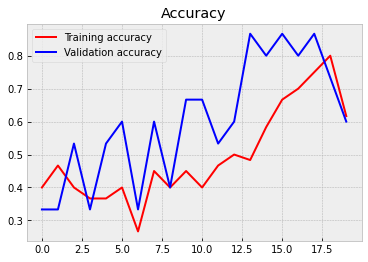

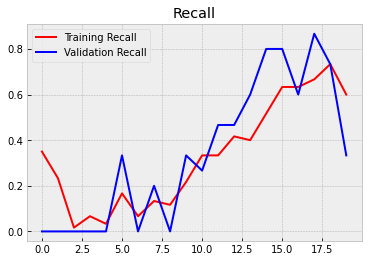

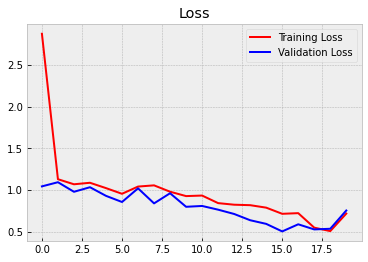

In [28]:
plt.style.use('bmh')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Recall')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [29]:
print(tf.__version__)

2.0.0


In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

## Transfer Learning

In [7]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 5s 1us/step


In [12]:
# This feature extractor converts each 160x160x3 image into a 7x7x1280 block of features.
feature_batch = base_model(X_test)
print(feature_batch.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(19, 7, 7, 1280)


### Freeze the model

In [15]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________